# **Steerable Quadrature Filters**

In this section we will dive deeper into Steerable Filters and learn about Steerable Quadrature Filters

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from test_image import get_test_image

A pair of filters is said to be in Quadrature if they have the same frequency response but differ in phase by 90 degrees. A common example of a Quadrature Pair is sine and cosine, they are 90 degrees out of phase with eachother, furthermore cosine is considered odd and sine is considered even. We will use the 2nd Derivative of the 2D Gaussian function as our even filter and we will approximate it's Hilbert transform to obtain it's Quadrature pair (odd filter).


Quadrature pairs enable the analysis of spectral strength independent of phase and allow for synthesizing filters of a given frequency response with arbitrary phase.

## **Construct the Filters**

The tables below show the basis filters and their coefficients. [source](http://people.csail.mit.edu/billf/publications/Design_and_Use_of_Steerable_Filters.pdf)

![](assets/table3.png)

![](assets/table5.png)

In [6]:
def gaussian2(x, y, a=1, mu_x=0, mu_y=0, sig_x=1, sig_y=1):
    """ 2D Gaussian Window Function
        Inputs:
            x - horizontal location argument
            y - vertical location argument
            a - scalar amplitude 
            mu_x - x (horizontal) mean (controls horizontal center)
            mu_y - y (vertical) mean (controls vertical center)
            sig_x - x (horizontal) standard deviation (controls horizontal spread)
            sig_y - y (vertical) standard deviation (controls vertical spread)
        Outputs:
            output 2D Gaussian Function Response at x, y
        """
    return a*np.exp(- (((x - mu_x)**2)/(sig_x**2)) - (((y - mu_y)**2)/(sig_y**2)) )



def even_filter(x, y, theta, a=1, mu_x=0, mu_y=0, sig_x=1, sig_y=1):
    """ 2nd Gaussian Derivative Steerable Even Filter G2
        Constructed by passing (Nx1) vectors tap indexes (x,y) locations 
        of desired filter. 
        Only valid for default 2D Gaussian Arguments.
        Inputs:
            x - (Nx1) horizontal location argument
            y - (Nx1) vertical location argument
            theta - steering angle in radians
        Outputs:
            filter value at (x,y) coordinates
    """
    window = gaussian2(x, y, a, mu_x, mu_y, sig_x, sig_y)

    g2a = 0.9213*(2*(x**2) - 1)*window
    g2b = 1.843*x*y*window
    g2c = 0.9213*(2*(y**2) - 1)*window

    ka = np.cos(theta)**2
    kb = -2*np.cos(theta)*np.sin(theta) 
    kc = np.sin(theta)**2

    return ka*g2a + kb*g2b + kc*g2c


def odd_filter(x, y, theta, a=1, mu_x=0, mu_y=0, sig_x=1, sig_y=1):
    """ 2nd Gaussian Derivative Steerable Odd Filter H2
        Constructed by passing (Nx1) vectors tap indexes (x,y) locations 
        of desired filter. Tap indexes correspond to offsets in either direction
        Only valid for default 2D Gaussian Arguments.
        Inputs:
            x - (Nx1) horizontal location argument
            y - (Nx1) vertical location argument
            theta - steering angle in radians
        Outputs:
            filter value at (x,y) coordinates
    """
    window = gaussian2(x, y, a, mu_x, mu_y, sig_x, sig_y)

    h2a = 0.9780*(-2.254*x + (x**3))*window
    h2b = 0.9780*(-0.7515 + (x**2))*y*window
    h2c = 0.9780*(-0.7515 + (y**2))*x*window
    h2d = 0.9780*(-2.254*y + (y**3))*window

    ka = np.cos(theta)**3
    kb = -3*(np.cos(theta)**2)*np.sin(theta)
    kc = 3*np.cos(theta)*(np.sin(theta)**2)
    kd = -(np.sin(theta)**3)

    return ka*h2a + kb*h2b + kc*h2c + kd*h2d


In [7]:
def get_xy(m, s=1):
    """ Obtains x and y indexes for desired number of filter taps 
        Inputs:
            m - number of taps (1 sided)
            s - spacing
        Outputs:
            x_indexes, y_indexes - column vectors of x and y indexes    
    """
    # range_index = np.arange(-(m+s), (m+s) + s, s)
    range_index = np.arange(-(m*s), (m*s) + s, s)
    x_index, y_index = np.meshgrid(range_index, range_index)
    x_index = x_index.reshape((-1, 1))
    y_index = y_index.reshape((-1, 1))

    return x_index, y_index

In [8]:
m = 4 # number of taps
s = 0.67 # spacing
theta = 0 # np.pi/4 # steering angle in radians

x_index, y_index = get_xy(m=m, s=s)
n = np.sqrt(x_index.shape[0]).astype(int)
G2 = even_filter(x_index, y_index, theta=theta).reshape((n, n))
H2 = odd_filter(x_index, y_index, theta=theta).reshape((n, n))

In [9]:
# m = 9 # 1 sided filter size (number of taps)
# x_index, y_index = np.meshgrid(np.arange(-m, m + 1), np.arange(-m, m + 1))
# x_index = x_index.reshape((-1, 1))
# y_index = y_index.reshape((-1, 1))

# G2 = even_filter(x_index, y_index, theta=0).reshape((m*2 + 1, m*2 + 1))
# H2 = odd_filter(x_index, y_index, theta=0).reshape((m*2 + 1, m*2 + 1))

In [10]:
G2.shape

(9, 9)

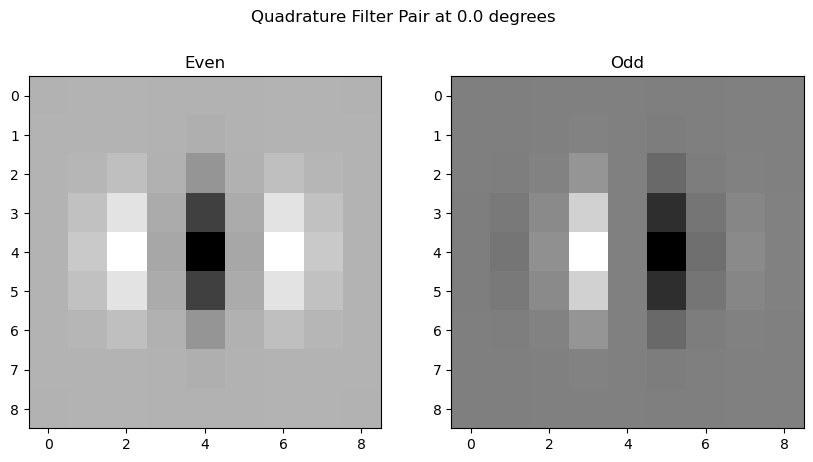

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"Quadrature Filter Pair at {np.degrees(theta)} degrees")
ax[0].imshow(G2, cmap='gray')
ax[0].set_title("Even")
ax[1].imshow(H2, cmap='gray')
ax[1].set_title("Odd");

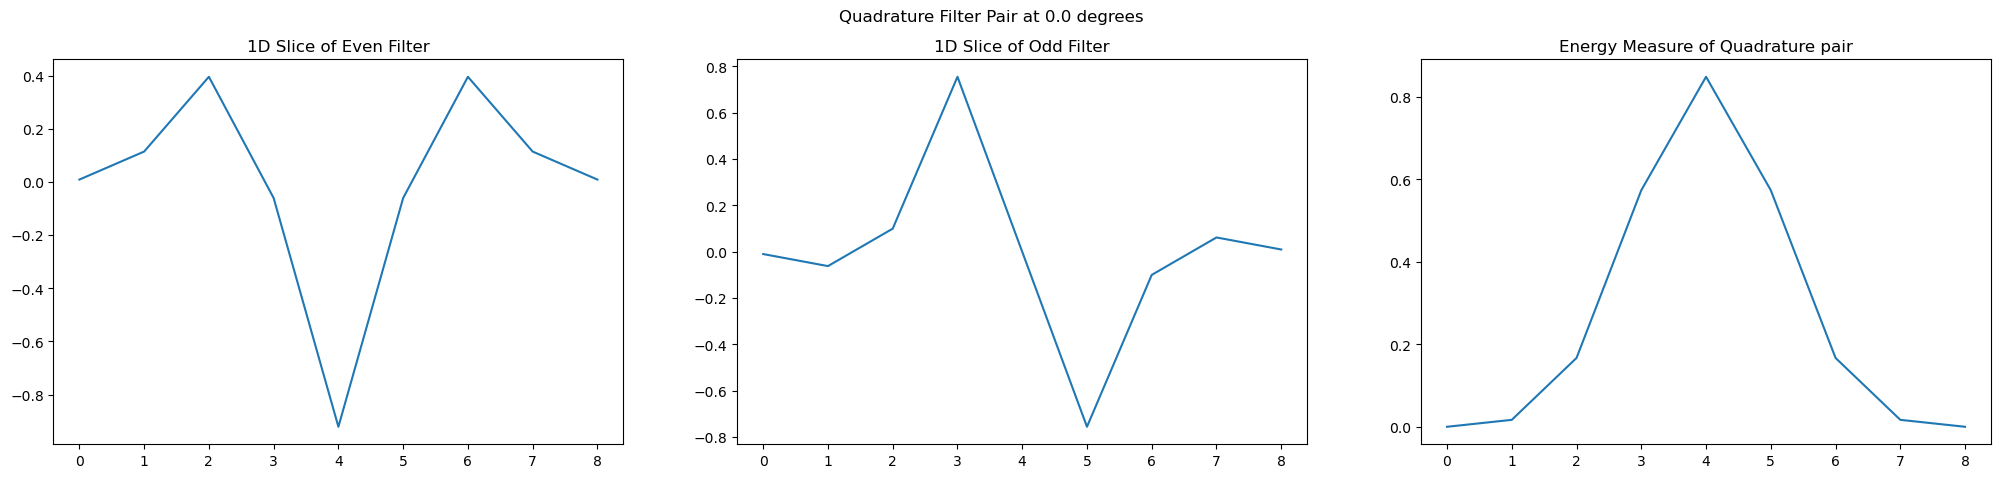

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
fig.suptitle(f"Quadrature Filter Pair at {np.degrees(theta)} degrees")
ax[0].plot(G2[n//2, :])
ax[0].set_title("1D Slice of Even Filter")
ax[1].plot(H2[n//2, :])
ax[1].set_title("1D Slice of Odd Filter"); 
ax[2].plot(G2[n//2, :]**2 + H2[n//2, :]**2)
ax[2].set_title("Energy Measure of Quadrature pair"); 

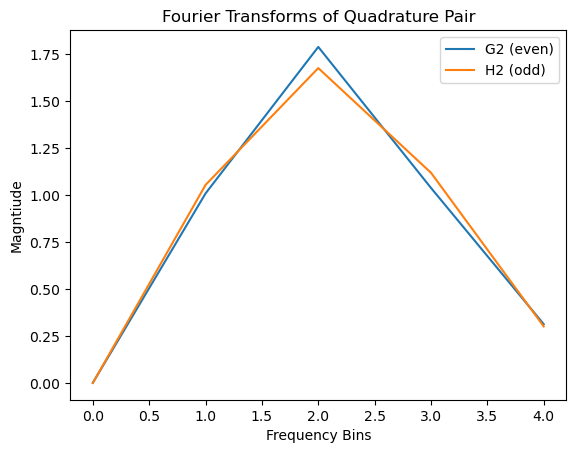

In [13]:
G2F = np.fft.rfft(G2[n//2, :])
H2F = np.fft.rfft(H2[n//2, :])

plt.plot(np.abs(G2F), label='G2 (even)')
plt.plot(np.abs(H2F), label='H2 (odd)');
plt.title("Fourier Transforms of Quadrature Pair");
plt.xlabel("Frequency Bins")
plt.ylabel("Magntiude")
plt.legend();

In [14]:
G2.sum(), H2.sum()

(-0.0014124543262402306, -2.288801608093735e-16)

### Get Results on Test Image

In [15]:
# get complex test image
test_image = get_test_image(512).astype(np.float32)

# 0-1 normalize
test_image = cv2.normalize(test_image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)

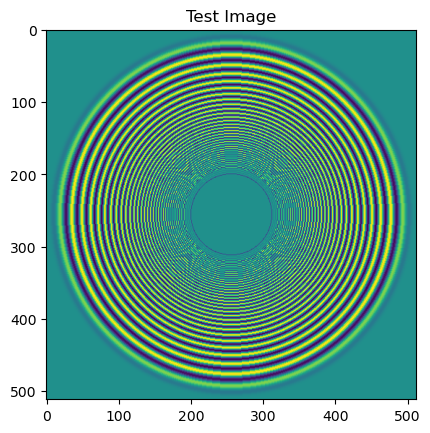

In [16]:
plt.imshow(test_image)
plt.title("Test Image");

In [17]:
RG2 = cv2.filter2D(test_image, ddepth=-1, kernel=G2)
RH2 = cv2.filter2D(test_image, ddepth=-1, kernel=H2)

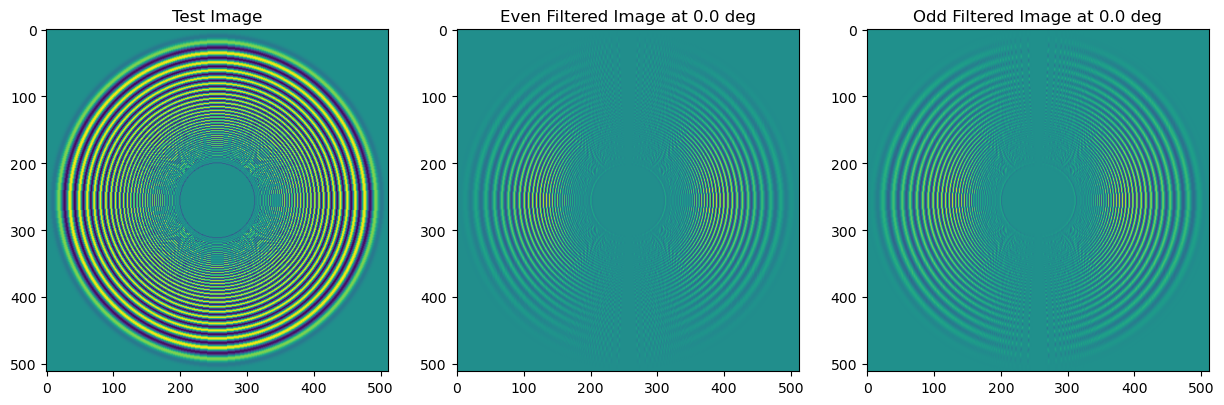

In [18]:
_, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(test_image)
ax[0].set_title("Test Image")
ax[1].imshow(RG2)
ax[1].set_title(f"Even Filtered Image at {np.degrees(theta)} deg");
ax[2].imshow(RH2)
ax[2].set_title(f"Odd Filtered Image at {np.degrees(theta)} deg");

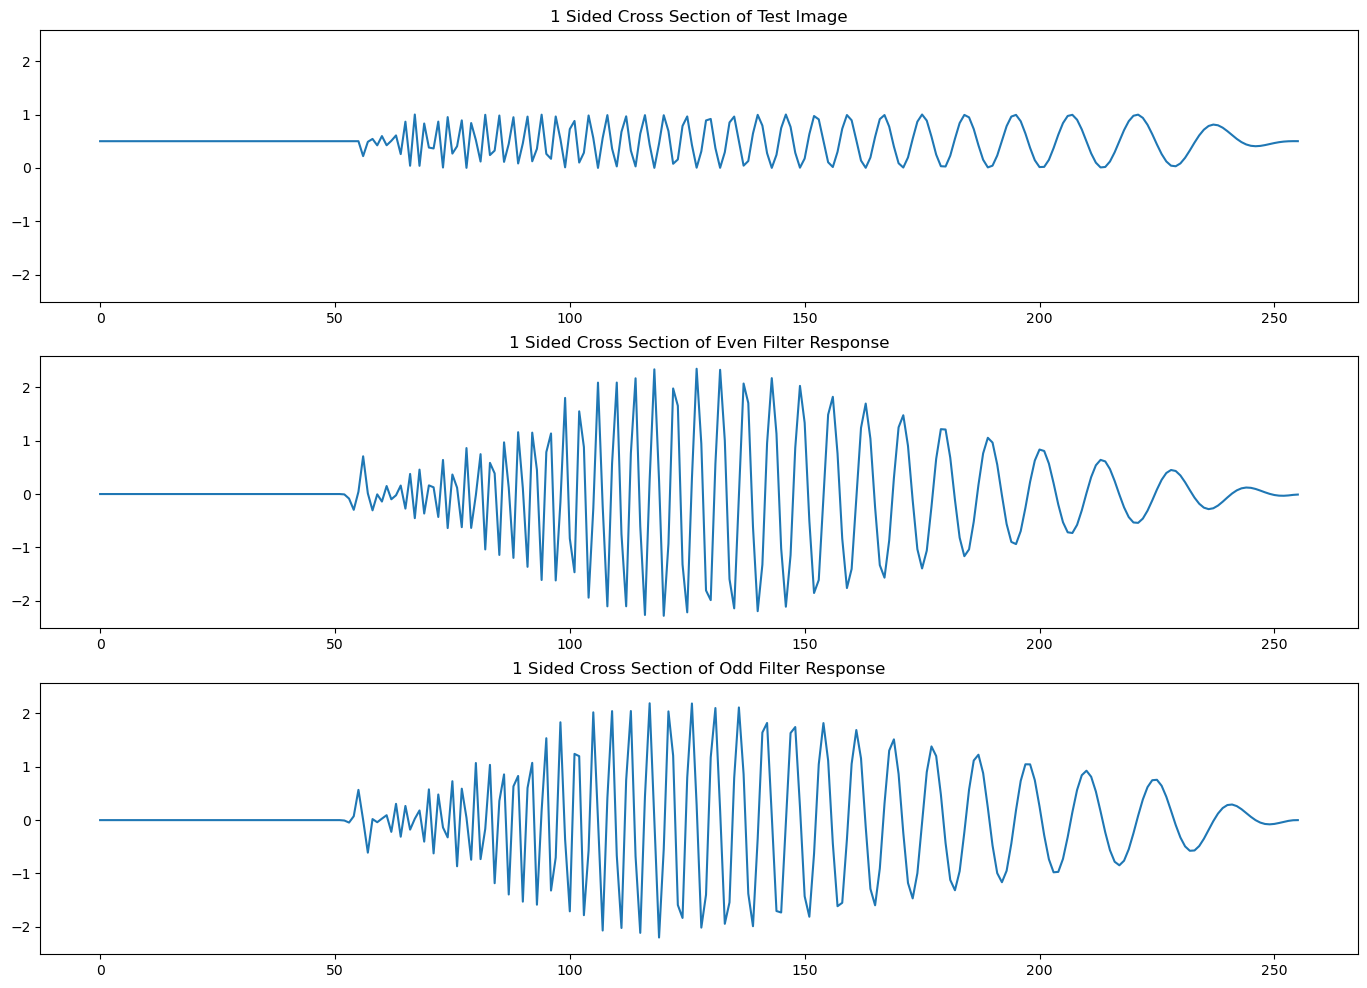

In [19]:
_, ax  = plt.subplots(3, 1, figsize=(17, 12), sharey=True)
ax[0].plot(test_image[256, 256:])
ax[0].set_title("1 Sided Cross Section of Test Image");
ax[1].plot(RG2[256, 256:])
ax[1].set_title("1 Sided Cross Section of Even Filter Response");
ax[2].plot(RH2[256, 256:])
ax[2].set_title("1 Sided Cross Section of Odd Filter Response");

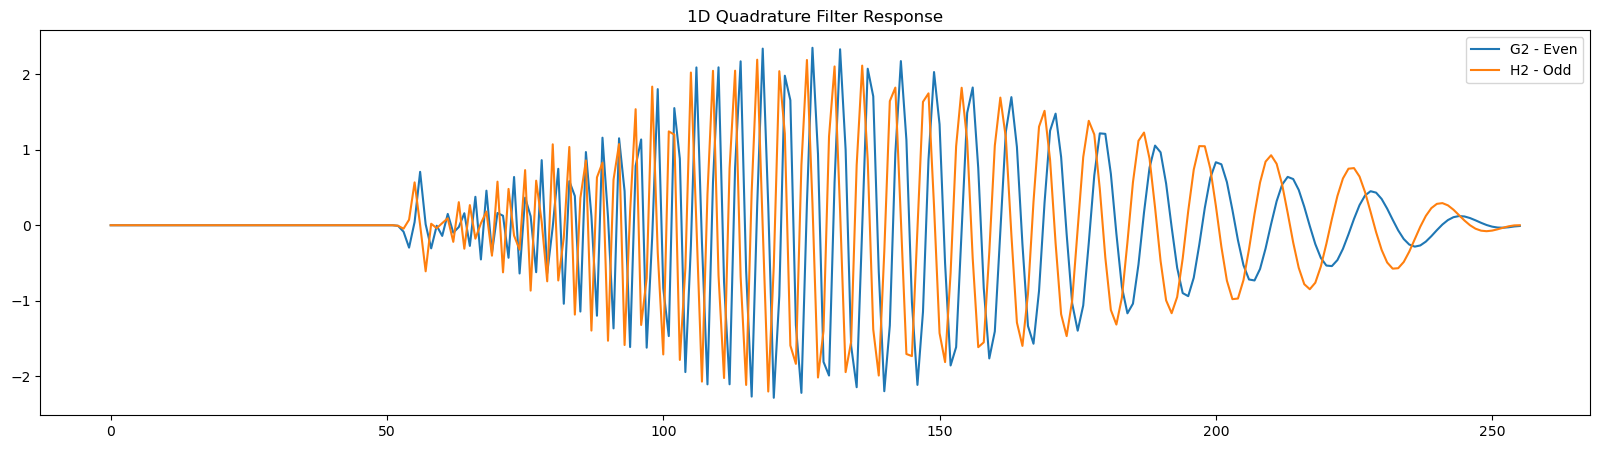

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(RG2[256, 256:], label='G2 - Even')
plt.plot(RH2[256, 256:], label='H2 - Odd')
plt.title("1D Quadrature Filter Response")
plt.legend();

In [21]:
angle = np.arctan2(RH2, RG2)
magnitude = np.sqrt(np.square(RG2**2 + RH2**2))

In [22]:
img_rows, img_cols = test_image.shape

In [23]:
orientations = np.zeros_like(test_image)
for i in range(4, img_rows, 4):
    for j in range(4, img_cols, 4):
        # print(i,j, angle[i,j], np.cos(angle[i,j]), np.sin(angle[i,j]))
        start_point = (j, i)
        end_point = (j + np.round(magnitude[i,j] * np.sin(angle[i,j])).astype(int),
                     i + np.round(magnitude[i,j] * np.cos(angle[i,j])).astype(int))
        cv2.line(orientations, start_point, end_point, (255,), 1)

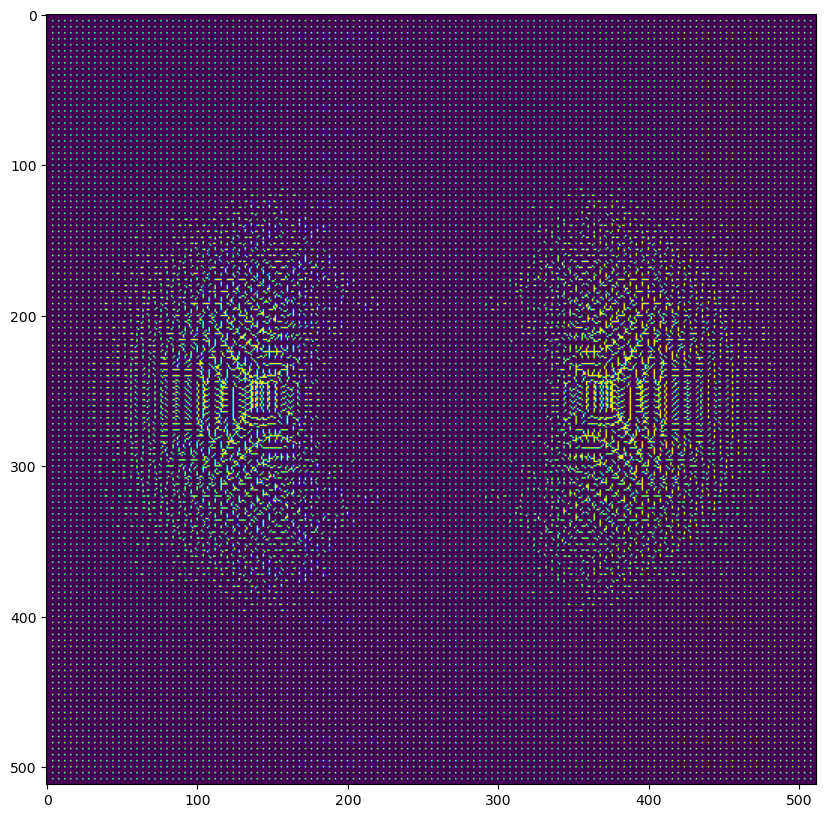

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(orientations);

In [35]:
from skimage.data import camera

test_image = camera()

test_image = cv2.normalize(test_image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)

In [36]:
RG2 = cv2.filter2D(test_image, ddepth=-1, kernel=G2)
RH2 = cv2.filter2D(test_image, ddepth=-1, kernel=H2)

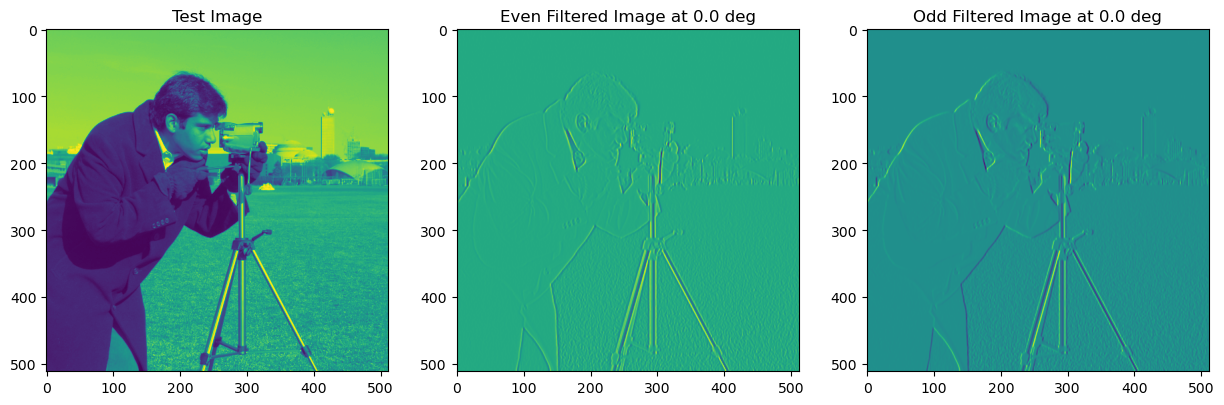

In [37]:
_, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(test_image)
ax[0].set_title("Test Image")
ax[1].imshow(RG2)
ax[1].set_title(f"Even Filtered Image at {np.degrees(theta)} deg");
ax[2].imshow(RH2)
ax[2].set_title(f"Odd Filtered Image at {np.degrees(theta)} deg");

Even Filter --> Lines <br>
Odd Filter --> Edges